# Food Delivery Time Prediction - Analysis

---

## Setup

As a first step, we import the necessary libraries and tools.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency

from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)


The dataset _Food_Delivery_Times_ is imported from the Git directory.  
After examining the contents of the database, we observe the presence of null values. It has been decided to remove these rows.  
Null values are removed because they can interfere with the calculations of the model, leading to inaccurate results.

In [2]:
Food = pd.read_csv("dataset/Food_Delivery_Times.csv")
print("Number of rows in the original dataset:", len(Food))

Food = Food.dropna()
print("Number of rows after removing missing values:", len(Food))

Food.head()


Number of rows in the original dataset: 1000
Number of rows after removing missing values: 883


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


---

# Simple Linear Regression

Before building regression models, we assess the quality of the dataset by analyzing the correlation between variables through the construction of a correlation matrix.  

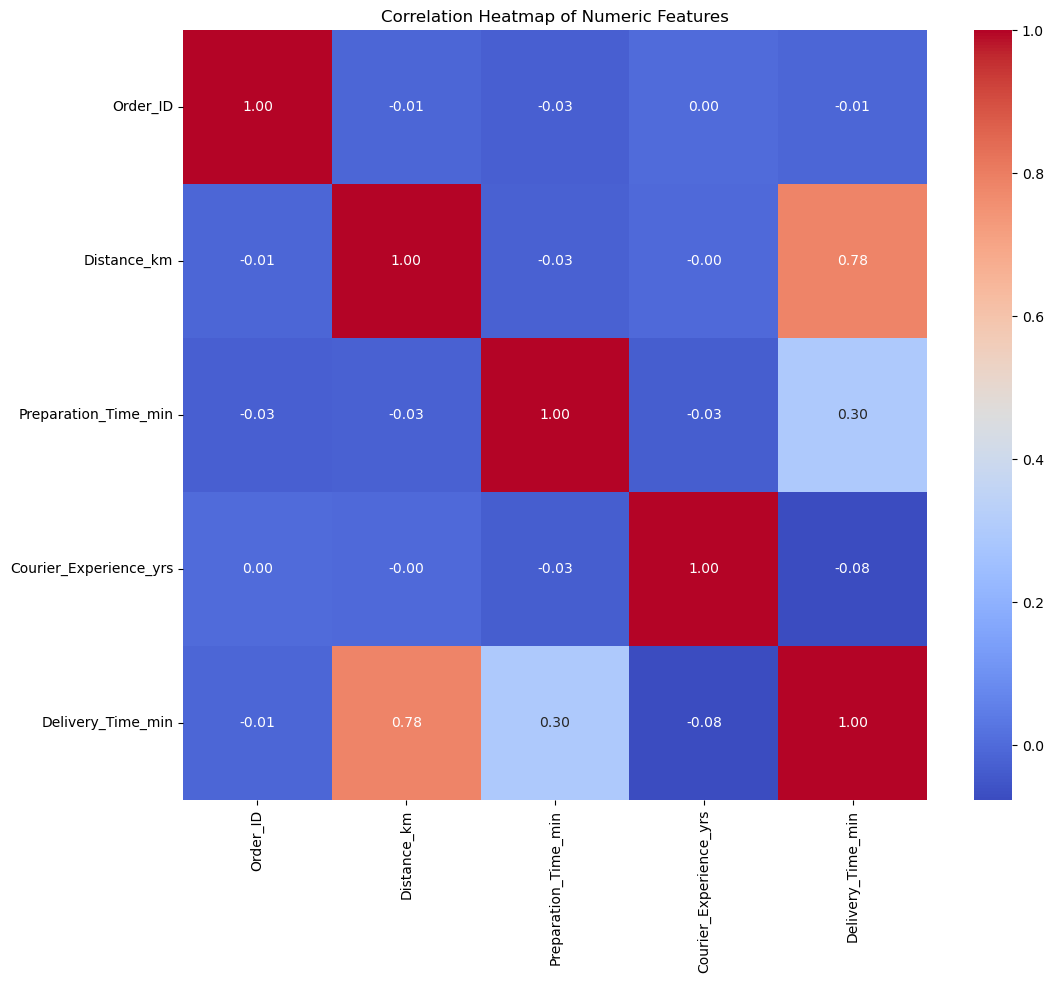

In [3]:
numeric_df = Food.select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 10))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()


In our case, some variables show a clear linear relationship with delivery time, indicating their potential importance in the regression model.  
Additionally, the predictors are not highly correlated with each other, suggesting that the dataset is suitable for linear regression and that multicollinearity is not a concern.


The three numerical variables (_Distance_km_, _Preparation_Time_min_, _Courier_Experience_yrs_) are selected, and the relationship between each of them and the response variable _Delivery_Time_min_ is analyzed individually.  
The variable _Order_ID_ is completely irrelevant to our objective, so we do not take it into account.

-  ## First case: 
#### _Delivery_Time_min_ = _b0_ + _b1_ * _Distance_km_ + _e_

In [4]:
X = pd.DataFrame({'intercept': np.ones(Food.shape[0]), 'Distance_km': Food['Distance_km']})
X[:4]

,intercept,Distance_km
0,1.0,7.93
1,1.0,16.42
2,1.0,9.52
3,1.0,7.44


In [5]:
y = Food['Delivery_Time_min']
model = sm.OLS(y, X) 
results = model.fit() 
summarize(results)

,coef,std err,t,P>|t|
intercept,26.5763,0.917,28.977,0.0
Distance_km,2.9696,0.079,37.391,0.0


_Distance_km_ has a p-value of 0.0, indicating that it is highly significant.  
The coefficient is positive, meaning that as the distance increases, the waiting time also increases.  
The intercept is high, suggesting that distance alone does not sufficiently explain the delivery times.  

#### Model prediction and confidence intervals

We define a linear regression design matrix including an intercept and the explanatory variable _Distance_km_ using the ModelSpec class from ISLP.  
This allows for consistent and automatic construction of the design matrix for both the original dataset and new observations.  

We then generate predictions and 95% confidence intervals for new values of _Distance_km_ based on the previously fitted model.


In [6]:
model = MS(['Distance_km'])
model = model.fit(Food) 
X = model.transform(Food)
X[:4]

,intercept,Distance_km
0,1.0,7.93
1,1.0,16.42
2,1.0,9.52
3,1.0,7.44


In [7]:
new_df = pd.DataFrame({'Distance_km':[10, 12, 14, 16, 20]})
newX = model.transform(new_df) 
newX

,intercept,Distance_km
0,1.0,10
1,1.0,12
2,1.0,14
3,1.0,16
4,1.0,20


In [8]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([56.27263106, 62.21189683, 68.15116261, 74.09042838, 85.96895994])

In [9]:
new_predictions.conf_int(alpha=0.05)

array([[55.38638325, 57.15887886],
       [61.27508791, 63.14870575],
       [67.07219764, 69.23012758],
       [72.80781444, 75.37304233],
       [84.18287461, 87.75504526]])

These intervals suggest that the model provides reasonably tight estimates for the predicted waiting times, with relatively small ranges around each predicted value.  
This indicates a good level of precision in the model's predictions.


### Graphs

1. #### Regression line

C:\Users\Asus\AppData\Local\Temp\ipykernel_8836\167901407.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)


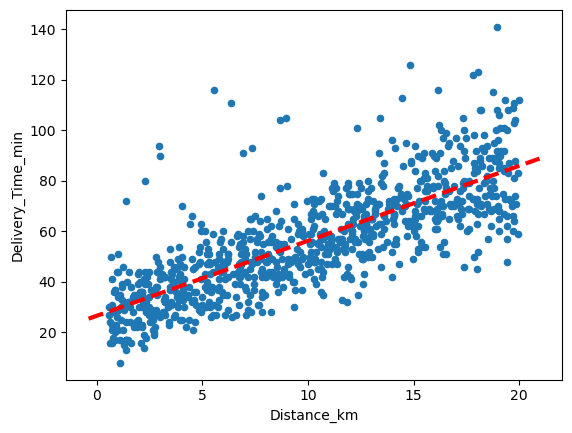

In [10]:
def abline(ax, b, m, *args, **kwargs):
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = Food.plot.scatter('Distance_km', 'Delivery_Time_min')
abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)

The scatter plot shows a positive correlation between distance in kilometers and delivery time in minutes.  
The data points align well with the linear trend line, indicating that the model is accurate and useful for predicting delivery times based on distance.

2. #### Fitted values vs residuals

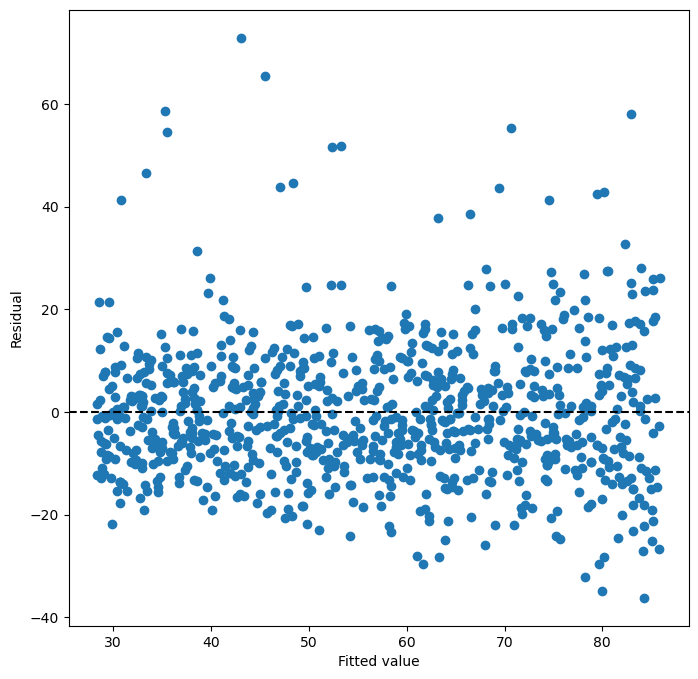

In [11]:
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.scatter(results.fittedvalues, results.resid)  
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')   

The residuals are spread around the zero line, indicating that the model fits the data well.  
There are no clear patterns in the residuals, suggesting the model's assumptions about linearity are valid.

3. #### Leverage

np.int64(356)

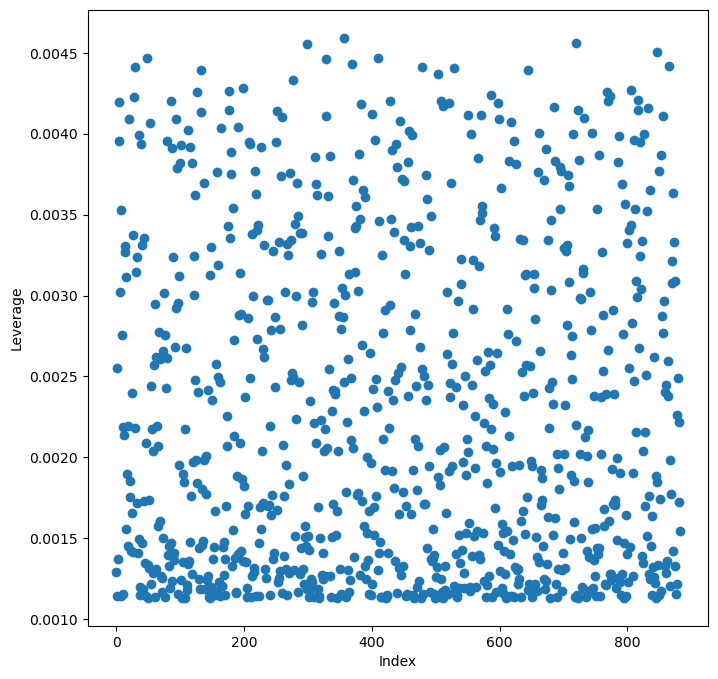

In [12]:
infl = results.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)


The leverage values are low, meaning no single data point has too much impact on the model.  
The leverage level for outliers is 0.0045. Since almost all data points are below this threshold, the model is well-balanced.



-  ## Second case: 
#### _Delivery_Time_min_ = _b0_ + _b1_ * _Preparation_Time_min_ + _e_

In [13]:
X = pd.DataFrame({'intercept': np.ones(Food.shape[0]), 'Preparation_Time_min': Food['Preparation_Time_min']})
X[:4]

,intercept,Preparation_Time_min
0,1.0,12
1,1.0,20
2,1.0,28
3,1.0,5


In [14]:
y = Food['Delivery_Time_min']
model = sm.OLS(y, X) 
results = model.fit() 
summarize(results)

,coef,std err,t,P>|t|
intercept,41.4331,1.768,23.428,0.0
Preparation_Time_min,0.8809,0.096,9.216,0.0


_Preparation_Time_min_ has a p-value of 0.0, indicating that it is highly significant.  
The coefficient is positive, meaning that as the preparation time increases, the waiting time also increases.  
The intercept is relatively high, suggesting that preparation time alone does not fully explain the total waiting time.  

#### Model prediction and confidence intervals

In [15]:
model = MS(['Preparation_Time_min'])
model = model.fit(Food) 
X = model.transform(Food)
X[:4]

,intercept,Preparation_Time_min
0,1.0,12
1,1.0,20
2,1.0,28
3,1.0,5


In [16]:
new_df = pd.DataFrame({'Preparation_Time_min':[10, 12, 14, 16, 20]})
newX = model.transform(new_df)
newX

,intercept,Preparation_Time_min
0,1.0,10
1,1.0,12
2,1.0,14
3,1.0,16
4,1.0,20


In [17]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([50.24239127, 52.00423977, 53.76608827, 55.52793678, 59.05163378])

In [18]:
new_predictions.conf_int(alpha=0.05)

array([[48.34841917, 52.13636337],
       [50.34902596, 53.65945359],
       [52.29167395, 55.2405026 ],
       [54.15330053, 56.90257302],
       [57.57997947, 60.52328809]])

These intervals indicate that the model produces slightly less accurate predictions for the waiting times than the previous model, with larger ranges surrounding each predicted value.  
This suggests that the model has a good degree of precision in its estimates.



### Graphs

1. #### Regression line

C:\Users\Asus\AppData\Local\Temp\ipykernel_8836\1700693636.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)


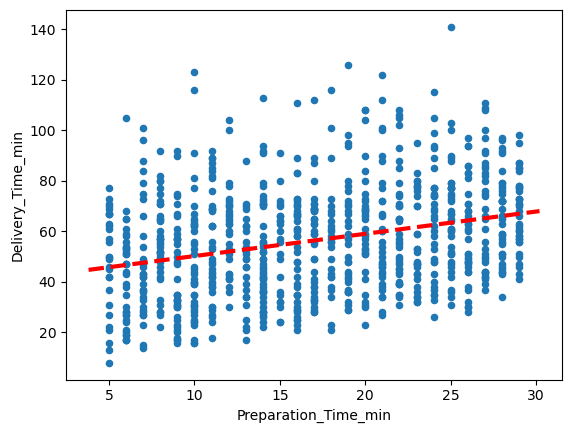

In [19]:
def abline(ax, b, m, *args, **kwargs):
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = Food.plot.scatter('Preparation_Time_min', 'Delivery_Time_min')
abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)

The scatter plot shows a positive correlation between preparation time and delivery time in minutes.  
The data points generally align with the linear trend line, suggesting that the model is reasonably good.  
However, compared to the previous model, the dispersion of the data points appears to increase.  
Additionally, there is noticeable vertical overlap between points at similar time values, indicating that other factors beyond distance may also influence delivery times.


2. #### Fitted values vs residuals

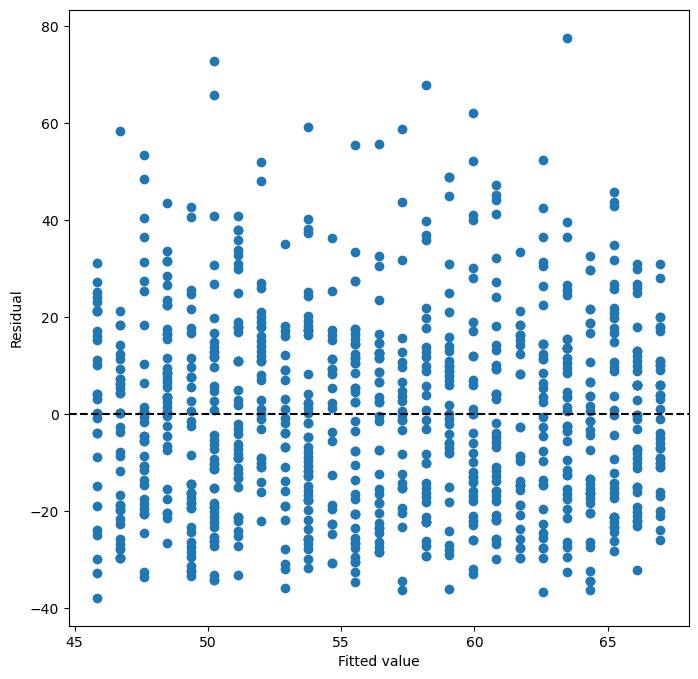

In [20]:
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.scatter(results.fittedvalues, results.resid)  
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')  

The residuals appear to be fairly symmetrically distributed above and below the zero line, which supports the assumption of linearity in the model.  
However, the residuals are widely spread, showing a noticeable vertical dispersion.

3. #### Leverage

np.int64(3)

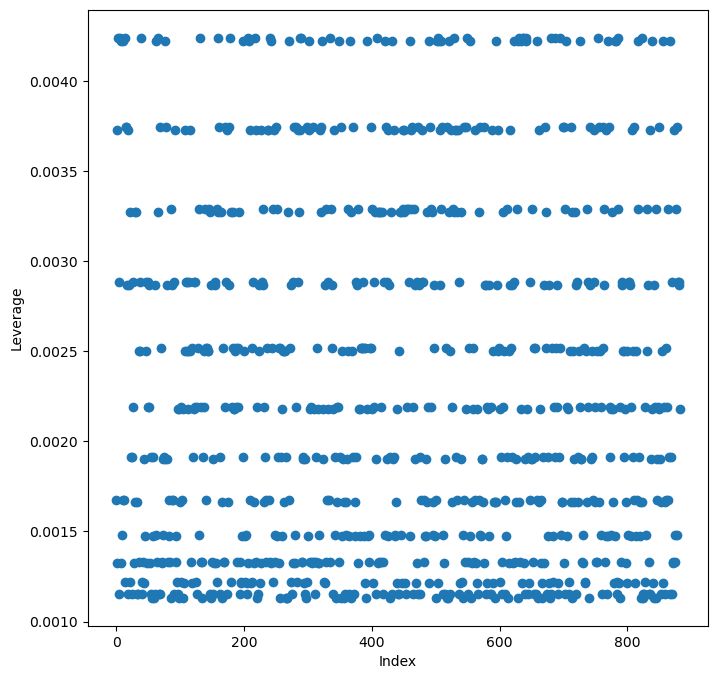

In [21]:
infl = results.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

Leverage values across the dataset are low, indicating that no individual observation exerts excessive influence on the model's predictions.  
The threshold for high leverage is 0.0045, and all points fall below this value.  
From this point of view, the model is very good.


-  ## Third case: 
#### _Delivery_Time_min_ = _b0_ + _b1_ * _Courier_Experience_yrs_ + _e_

In [22]:
X = pd.DataFrame({'intercept': np.ones(Food.shape[0]), 'Courier_Experience_yrs': Food['Courier_Experience_yrs']})
X[:4]

,intercept,Courier_Experience_yrs
0,1.0,1.0
1,1.0,2.0
2,1.0,1.0
3,1.0,1.0


In [23]:
y = Food['Delivery_Time_min']
model = sm.OLS(y, X) 
results = model.fit() 
summarize(results)

,coef,std err,t,P>|t|
intercept,59.0555,1.359,43.445,0.000
Courier_Experience_yrs,-0.5668,0.248,-2.286,0.022


_Courier_Experience_yrs_ has a p-value of 0.022, indicating that it is significant.  
The coefficient is negative, meaning that as courier experience increases, the waiting time tends to decrease.  
The intercept is relatively high, suggesting that courier experience alone does not fully account for the variability in waiting times.  
Compared to the previous models, _Courier_Experience_yrs_ has a smaller effect size and slightly higher uncertainty, as reflected in the standard error and t-statistic.


#### Model prediction and confidence intervals

In [24]:
model = MS(['Courier_Experience_yrs'])
model = model.fit(Food)
X = model.transform(Food)
X[:4]

,intercept,Courier_Experience_yrs
0,1.0,1.0
1,1.0,2.0
2,1.0,1.0
3,1.0,1.0


In [25]:
new_df = pd.DataFrame({'Courier_Experience_yrs':[1, 3, 5, 7, 10]})
newX = model.transform(new_df)
newX

,intercept,Courier_Experience_yrs
0,1.0,1
1,1.0,3
2,1.0,5
3,1.0,7
4,1.0,10


In [26]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([58.48877418, 57.35524114, 56.22170809, 55.08817505, 53.38787548])

In [27]:
new_predictions.conf_int(alpha=0.05)

array([[56.21788403, 60.75966433],
       [55.72536108, 58.9851212 ],
       [54.78977201, 57.65364417],
       [53.2609537 , 56.9153964 ],
       [50.41750217, 56.35824879]])

The intervals show that the model generates fairly precise predictions for the waiting times, with usually small variations around each predicted value.  
This reflects a decent level of accuracy in the model's forecasts.


### Graphs

1. #### Regression line

C:\Users\Asus\AppData\Local\Temp\ipykernel_8836\381901448.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)


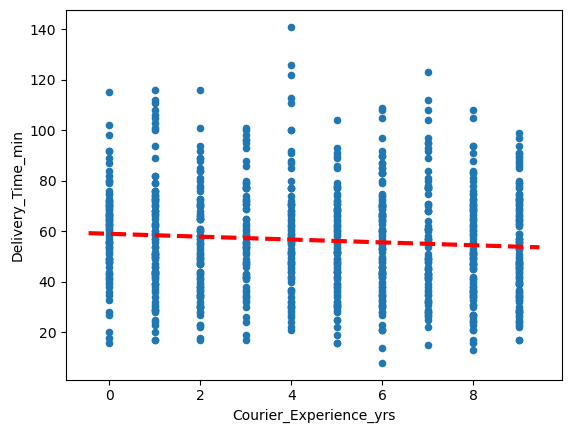

In [28]:
def abline(ax, b, m, *args, **kwargs):
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

ax = Food.plot.scatter('Courier_Experience_yrs', 'Delivery_Time_min')
abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)

The plot shows that the trend line is slightly downward, indicating a weak negative relationship between preparation time and delivery time.  
The data points are highly dispersed around the trend line, suggesting that the model does not adequately explain the variability in the data.  
Additionally, there is considerable vertical overlap between the points, which indicates that factors beyond experience may significantly influence delivery times.  
This suggests the possibility of a nonlinear relationship, and the model is likely the worst one so far.


2. #### Fitted values vs residuals

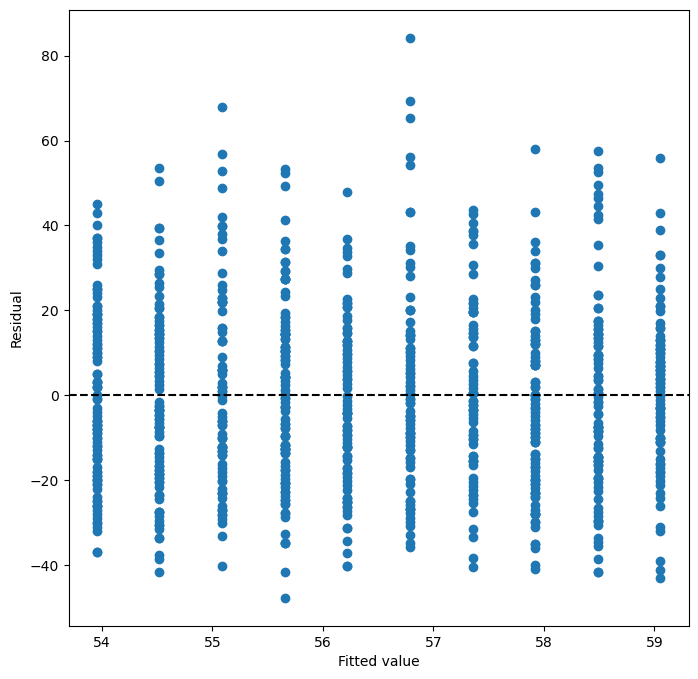

In [29]:
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.scatter(results.fittedvalues, results.resid)  
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')  

In this case as well, the residuals are symmetric but very large, indicating poor accuracy.

3. #### Leverage

np.int64(18)

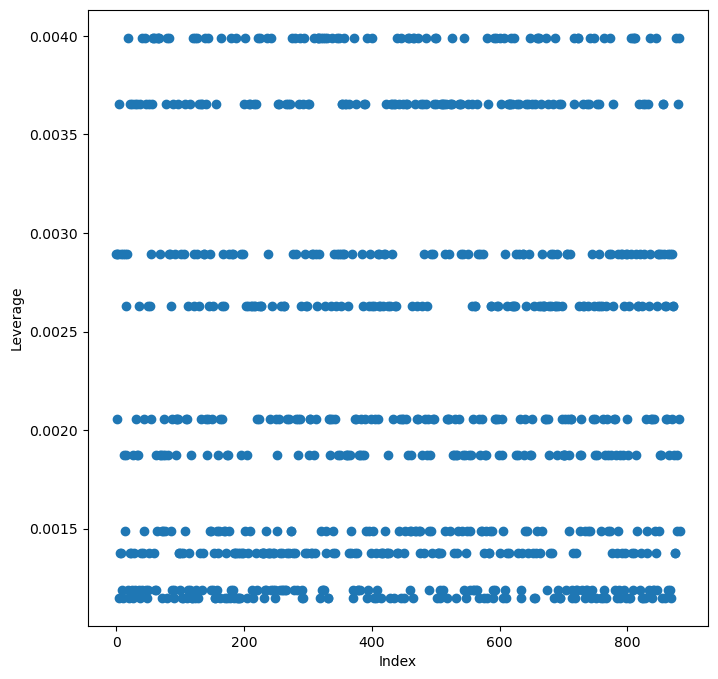

In [30]:
infl = results.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

No point has high leverage, meaning no single point dominates the model's estimation.  
This is positive, but it also confirms that no single observation provides strong information to the model, which is consistent with the fact that the model does not adequately explain the variability in the data.


---

# Multiple Linear Regression
#### _Delivery_Time_min_ = _b0_ + _b1_ * _Distance_km_ + _b2_ * _Preparation_Time_min_ + _b3_ * _Courier_Experience_yrs_ + _e_

In [31]:
X = MS(['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']).fit_transform(Food)
y = Food['Delivery_Time_min']

model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,12.5721,1.373,9.159,0.0
Distance_km,2.9993,0.068,44.137,0.0
Preparation_Time_min,0.9350,0.053,17.552,0.0
Courier_Experience_yrs,-0.4756,0.132,-3.595,0.0


The results of the linear regression model indicate that distance, preparation time, and courier experience significantly influence food delivery time (p-values = 0).  
Specifically, delivery time increases by approximately 3.00 minutes per additional kilometer.  
It also increases by 0.94 minutes for each additional minute of preparation.  
In contrast, each additional year of courier experience reduces delivery time by about 0.48 minutes.


In [32]:
print("R2", results.rsquared) 
print("RSE", np.sqrt(results.scale))

R2 0.7178382884665467
RSE 11.476474058251675


The linear regression model explains approximately 71.8% of the variance in food delivery time (R² = 0.7178), indicating a strong fit.  
The residual standard error (RSE) is 11.48 minutes, suggesting a moderate prediction error given the likely range of delivery times.  
Overall, the model performs well.

---

## Qualitative predictors

Now we examine the remaining variables, which are categorical.


In [33]:
for col in Food.columns:
    if Food[col].dtype == 'object':
        print(f"{col}: {Food[col].unique()}")

Weather: ['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy']
Traffic_Level: ['Low' 'Medium' 'High']
Time_of_Day: ['Afternoon' 'Evening' 'Night' 'Morning']
Vehicle_Type: ['Scooter' 'Bike' 'Car']


Before creating the new model, we verify that the categorical variables are not strongly correlated with each other, ensuring that each one contributes useful information to the model.  
Since the variables are not numerical, we cannot use a standard correlation matrix.  
Instead, we use Cramér's V, a statistical measure of association between two categorical variables, which ranges from 0 (no association) to 1 (perfect association).


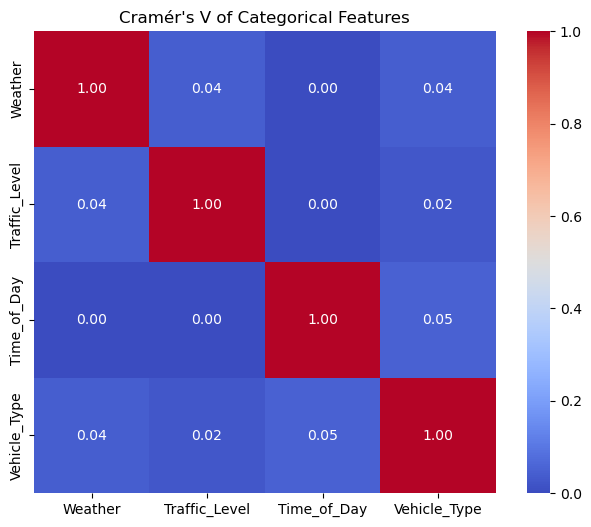

In [34]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
Food[categorical] = Food[categorical].astype('category')

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1)) 
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

cramer_matrix = pd.DataFrame(
    np.zeros((len(categorical), len(categorical))),
    index=categorical,
    columns=categorical
)

for var1 in categorical:
    for var2 in categorical:
        cramer_matrix.loc[var1, var2] = cramers_v(Food[var1], Food[var2])

plt.figure(figsize=(8,6))
sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Cramér's V of Categorical Features")
plt.show()


The Cramér’s V matrix shows very low values (all < 0.05), indicating that the categorical variables are essentially independent from each other.  
No significant associations emerge, suggesting that each variable provides distinct and non-redundant information to the model.


Using the tools from ISLP, we build a regression model that includes all variables, both numerical and categorical.  
Categorical variables are automatically handled by the library through one-hot encoding, a process that transforms each category into a separate binary variable.  
This allows the model to interpret categorical information in a numerical form suitable for linear regression.


In [35]:
model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience_yrs'
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

model = sm.OLS(y, X)
results = model.fit()
summarize(results)


,coef,std err,t,P>|t|
intercept,17.6080,1.557,11.306,0.000
Distance_km,2.9578,0.060,49.632,0.000
Weather[Foggy],7.7861,1.126,6.917,0.000
Weather[Rainy],4.9064,0.882,5.561,0.000
Weather[Snowy],9.8455,1.196,8.233,0.000
Weather[Windy],2.1304,1.194,1.785,0.075
Traffic_Level[Low],-12.0985,0.922,-13.116,0.000
Traffic_Level[Medium],-6.0541,0.918,-6.595,0.000
Time_of_Day[Evening],0.6481,0.876,0.740,0.460
Time_of_Day[Morning],-0.7089,0.868,-0.817,0.414


From the regression results, several observations can be made:  
- _Distance_km_ has a strong and significant positive effect on delivery time.  
- Adverse weather conditions like _Foggy_, _Rainy_, and _Snowy_ significantly increase delivery time, compared to _Clear_ weather.  
- _Traffic_Level[Low]_ and _Medium_ significantly reduce delivery time compared to _High_ traffic, which is the baseline.  
- Different times of the day (_Morning_, _Evening_, _Night_) do not show statistically significant differences (p-values > 0.05) from the baseline (_Afternoon_).  
- Similarly, neither _Car_ nor _Scooter_ types show significant differences (p-values > 0.05) from the baseline vehicle (_Bike_), suggesting that vehicle type may not strongly influence delivery time in this model.  
- _Preparation_Time_min_ significantly increases delivery time, as expected.  
- Interestingly, _Courier_Experience_yrs_ is negatively associated with delivery time, indicating that more experienced couriers tend to deliver faster.


In [36]:
print("R2", results.rsquared) 
print("RSE", np.sqrt(results.scale))

R2 0.7878987131707718
RSE 10.013033415147554


The linear regression model now explains approximately 78% of the variance in food delivery time, indicating an even stronger fit compared to the previous model (R² = 0.7178).  
The residual standard error is now 10 minutes, suggesting a slight improvement in prediction accuracy, with a lower error compared to the previous model (RSE = 11.48 minutes).  
Overall, the model has improved in both explanatory power and prediction accuracy.


# Gab, quale modello scegliamo?



In [37]:
#Tolte veicolo e ora del giorno

categorical = ['Weather', 'Traffic_Level']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Preparation_Time_min',
    'Courier_Experience_yrs',
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']


model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,17.0725,1.433,11.917,0.000
Distance_km,2.9586,0.060,49.667,0.000
Weather[Foggy],7.7795,1.126,6.909,0.000
Weather[Rainy],4.9920,0.881,5.663,0.000
Weather[Snowy],10.0757,1.191,8.463,0.000
Weather[Windy],2.1777,1.191,1.828,0.068
Traffic_Level[Low],-12.0368,0.922,-13.057,0.000
Traffic_Level[Medium],-6.1083,0.918,-6.654,0.000
Preparation_Time_min,0.9531,0.047,20.435,0.000
Courier_Experience_yrs,-0.5474,0.116,-4.710,0.000


In [38]:
print("R2", results.rsquared) 
print("RSE", np.sqrt(results.scale))

R2 0.7863372179422445
RSE 10.021003042437089


In [39]:
#Tutte + interazione veicolo e traffico

Food['Vehicle_Traffic_Interaction'] = Food['Vehicle_Type'].astype(str) + "_" + Food['Traffic_Level'].astype(str)
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Vehicle_Traffic_Interaction']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience_yrs',
    'Vehicle_Traffic_Interaction',
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']


model = sm.OLS(y, X)
results = model.fit()
summarize(results)






,coef,std err,t,P>|t|
intercept,17.5356,1.689,10.384,0.000
Distance_km,2.9579,0.060,49.444,0.000
Weather[Foggy],7.8015,1.131,6.899,0.000
Weather[Rainy],4.9818,0.889,5.604,0.000
Weather[Snowy],9.8603,1.198,8.230,0.000
Weather[Windy],2.1810,1.198,1.820,0.069
Traffic_Level[Low],-8.4638,0.677,-12.495,0.000
Traffic_Level[Medium],-3.8799,0.682,-5.686,0.000
Time_of_Day[Evening],0.6728,0.879,0.765,0.444
Time_of_Day[Morning],-0.6730,0.872,-0.772,0.441


In [40]:
print("R2", results.rsquared) 
print("RSE", np.sqrt(results.scale))

R2 0.7882140725613282
RSE 10.028721122808244


In [41]:
#Tolte veicolo e ora del giorno + interazione veicolo e traffico

Food['Vehicle_Traffic_Interaction'] = Food['Vehicle_Type'].astype(str) + "_" + Food['Traffic_Level'].astype(str)
categorical = ['Weather', 'Time_of_Day', 'Vehicle_Traffic_Interaction']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Time_of_Day',
    'Preparation_Time_min',
    'Courier_Experience_yrs',
    'Vehicle_Traffic_Interaction',
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']


model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,17.5356,1.689,10.384,0.000
Distance_km,2.9579,0.060,49.444,0.000
Weather[Foggy],7.8015,1.131,6.899,0.000
Weather[Rainy],4.9818,0.889,5.604,0.000
Weather[Snowy],9.8603,1.198,8.230,0.000
Weather[Windy],2.1810,1.198,1.820,0.069
Time_of_Day[Evening],0.6728,0.879,0.765,0.444
Time_of_Day[Morning],-0.6730,0.872,-0.772,0.441
Time_of_Day[Night],-1.2751,1.321,-0.965,0.335
Preparation_Time_min,0.9525,0.047,20.369,0.000


In [42]:
print("R2", results.rsquared) 
print("RSE", np.sqrt(results.scale))

R2 0.7882140725613282
RSE 10.028721122808244


In [ ]:

#Tolte + interazione veicolo e traffico + interazione traffico e quando nel giorno
Food['Traffic_Time_Interaction'] = Food['Traffic_Level'].astype(str) + "_" + Food['Time_of_Day'].astype(str)
Food['Vehicle_Traffic_Interaction'] = Food['Vehicle_Type'].astype(str) + "_" + Food['Traffic_Level'].astype(str)
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Vehicle_Traffic_Interaction', 'Traffic_Time_Interaction']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Preparation_Time_min',
    'Courier_Experience_yrs',
    'Vehicle_Traffic_Interaction',
    'Traffic_Time_Interaction',
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']


model = sm.OLS(y, X)
results = model.fit()
summarize(results)






,coef,std err,t,P>|t|
intercept,18.6630,2.005,9.309,0.000
Distance_km,2.9582,0.060,49.378,0.000
Weather[Foggy],7.5862,1.141,6.650,0.000
Weather[Rainy],4.9603,0.891,5.570,0.000
Weather[Snowy],9.8654,1.203,8.198,0.000
Weather[Windy],2.0530,1.208,1.699,0.090
Preparation_Time_min,0.9533,0.047,20.298,0.000
Courier_Experience_yrs,-0.5565,0.117,-4.741,0.000
Vehicle_Traffic_Interaction[Bike_Low],-7.1526,1.155,-6.190,0.000
Vehicle_Traffic_Interaction[Bike_Medium],-4.3343,1.139,-3.805,0.000


In [55]:
print("R2", results.rsquared) 
print("RSE", np.sqrt(results.scale))

R2 0.7892634170340312
RSE 10.038762954366353


---

# Cross Validation

### Validation set approach

In [45]:
from functools import partial
from sklearn.model_selection import (cross_validate ,KFold ,ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm #a wrapper that enables us to easily use the cross-validation tools of sklearn with models fit by statsmodels
from sklearn.model_selection import train_test_split

In [46]:
Auto = load_data('Auto')
Auto_train , Auto_valid = train_test_split(Auto, test_size=196, random_state=0) # random_state is needed for reproducible result across run

In [47]:
#fit a linear regression model
hp_mm = MS(['horsepower'])
X_train = hp_mm.fit_transform(Auto_train)
y_train = Auto_train['mpg']
model = sm.OLS(y_train , X_train)
results = model.fit()

In [48]:
# evaluate the model using the MSE on the validation data
X_valid = hp_mm.transform(Auto_valid)
y_valid = Auto_valid['mpg']
valid_pred = results.predict(X_valid)
np.mean((y_valid - valid_pred)**2)
#Con questa tecnica il mean squared error è molto variabile perchè abbiamo preso random metà del dataset. Quelli sotto sono più precisi

np.float64(23.616617069669882)

## Leave One-out Cross validation
The sklearn_sm() class takes a statsmodels model as its first argument. It also accepts two optional arguments: model_str for specifying a formula, and model_args, which is a dictionary containing additional arguments for fitting the model.

In [49]:
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']

# This is a LOOCV because cv use the number of sample in our dataset, that is Auto.shape[0], making sure that each sample is use as a test set
cv_results = cross_validate(hp_model ,X, Y, cv=Auto.shape[0]) # Con cv imposto la fold uguale a n, ogni volta toglie 1 elemento dal dataset
cv_err = np.mean(cv_results['test_score'])
cv_err 
# Questo metodo è il più preciso ma il più lento

np.float64(24.231513517929233)

## K-Fold cross validation

In [50]:
hp_model = sklearn_sm(sm.OLS, MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_validate(hp_model, X, Y, cv=kf)
cv_err = np.mean(cv_results['test_score'])
cv_err
# Via di mezzo tra i due precedenti

np.float64(24.09767573188305)